## Step 1: Setup & Compatibility

In [2]:
import os
import sys
import types
import pandas as pd

# ---------------------------------------------------------
# 1. Pandas Shim (Keep this)
# ---------------------------------------------------------
numeric_module = types.ModuleType("pandas.core.indexes.numeric")
class Int64Index(pd.Index): pass
numeric_module.Int64Index = Int64Index
sys.modules["pandas.core.indexes.numeric"] = numeric_module

# ---------------------------------------------------------
# 2. ROBUST PATH SETUP (The Fix)
# ---------------------------------------------------------
current_dir = os.getcwd()
print(f"[DEBUG] Current working dir: {current_dir}")

# Check if 'src' is in the current folder
if "src" in os.listdir(current_dir):
    project_root = current_dir
    print("[INFO] Found 'src' in current directory.")
else:
    # Check if we are inside 'src' or a subfolder, and need to go up
    parent_dir = os.path.dirname(current_dir)
    if "src" in os.listdir(parent_dir):
        project_root = parent_dir
        print(f"[INFO] Found 'src' in parent directory: {project_root}")
    else:
        # HARD FALLBACK for your specific system
        project_root = r"E:\Ignite Hack"
        print(f"[WARNING] Could not auto-detect. Forcing root: {project_root}")

# Add to sys.path if not present
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"[INFO] Final System Path added: {project_root}")

# ---------------------------------------------------------
# 3. Import Project Modules
# ---------------------------------------------------------
try:
    from src.model import CNNMultiLabelECG
    from src.evaluate import evaluate_multilabel
    from src.preprocessing import ECGPreprocessor
    print("\n[SUCCESS] All modules imported correctly!")
except ImportError as e:
    print(f"\n[CRITICAL ERROR] Import failed: {e}")
    print(f"Contents of {project_root}: {os.listdir(project_root)}")

[DEBUG] Current working dir: E:\Ignite Hack\notebooks
[INFO] Found 'src' in parent directory: E:\Ignite Hack
[INFO] Final System Path added: E:\Ignite Hack

[SUCCESS] All modules imported correctly!


## Step 2: Device (CUDA Proof)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"[INFO] CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("[INFO] Apple MPS")
else:
    device = torch.device("cpu")
    print("[WARNING] CPU only")

[INFO] CUDA: NVIDIA GeForce RTX 2050


## Step 3: Validation Dataset (Lazy, Safe)

In [4]:
VAL_DIR = r"E:\Ignite Hack\data\processed\val_split\250Hz\60s"

class LazyECGDataset(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.files = [f for f in os.listdir(folder) if f.endswith(".pk")]
        self.prep = ECGPreprocessor()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(os.path.join(self.folder, self.files[idx]), "rb") as f:
            sig_df, lbl_dict = pickle.load(f)
        sig = self.prep.preprocess(sig_df.values.T.astype(np.float32))
        lbl = lbl_dict["classes_one_hot"].values.astype(np.float32)
        return torch.tensor(sig), torch.tensor(lbl)

val_ds = LazyECGDataset(VAL_DIR)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

print(f"[INFO] Validation samples: {len(val_ds)}")

[INFO] Validation samples: 1095


## Step 4: Load Trained Model (.pth)

In [7]:
MODEL_PATH = r"E:\Ignite Hack\ecg_model_v1.pth"

In [8]:
model = CNNMultiLabelECG(num_classes=9)

# 3. Load Weights
# map_location ensures weights load to the correct device memory initially
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# 4. CRITICAL: Move model to device explicitly
model.to(device)
model.eval()
print(f"[INFO] Model loaded and moved to {device}")

[INFO] Model loaded and moved to cuda


C:\Users\Surya Teja\AppData\Local\Temp\ipykernel_15508\1839460836.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_locati

## Step 5: Baseline Evaluation (Default Threshold = 0.5)

In [9]:
y_true, y_prob = [], []

print("[INFO] Starting Inference Loop...")
with torch.no_grad():
    for X, y in tqdm(val_loader, desc="Inference"):
        # Move inputs to the SAME device as the model
        X = X.to(device) 
        
        # Model forward pass
        preds = model(X)
        
        # Move back to CPU for storage
        y_prob.append(preds.cpu().numpy())
        y_true.append(y.numpy())

# 6. Stack results
y_true = np.vstack(y_true)
y_prob = np.vstack(y_prob)

print(f"[SUCCESS] Inference complete. Output shape: {y_prob.shape}")

# 7. Evaluate
metrics_base, aucs_base = evaluate_multilabel(y_true, y_prob) # Removed threshold=0.5 to use adaptive logic
print("\nMetrics:")
print(metrics_base)

[INFO] Starting Inference Loop...


Inference: 100%|███████████████████████████████████████████████████████████████████████| 35/35 [00:18<00:00,  1.85it/s]


[SUCCESS] Inference complete. Output shape: (1095, 9)

Metrics:
{'Best Threshold': np.float64(0.40000000000000013), 'Hamming Loss': 0.043125317097919835, 'Subset Accuracy': 0.7406392694063927, 'F1 Macro': 0.772704168055433, 'F1 Micro': 0.8238707003729797}


## Step 6: Loss Function Comparison (BCE vs Focal)

In [10]:
from sklearn.metrics import f1_score, hamming_loss

def metrics_at_threshold(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "Hamming": hamming_loss(y_true, y_pred),
        "F1_macro": f1_score(y_true, y_pred, average="macro"),
        "F1_micro": f1_score(y_true, y_pred, average="micro"),
    }

metrics_bce_like = metrics_at_threshold(y_true, y_prob, 0.5)   # BCE-style default
metrics_bce_like

{'Hamming': 0.038559107052257735,
 'F1_macro': 0.7652973039428783,
 'F1_micro': 0.8308103294746215}

## Step 7: Class Imbalance Analysis (Validation Set)

In [11]:
class_counts = y_true.sum(axis=0)
label_names = ["AF","LBBB","RBBB","PAC","PVC","STD","STE","Normal","Other"]

imb_df = pd.DataFrame({
    "Class": label_names,
    "Positive_Count": class_counts,
    "Prevalence_%": (class_counts / len(y_true)) * 100
}).sort_values("Positive_Count")

imb_df

,Class,Positive_Count,Prevalence_%
7,Normal,34.0,3.105023
2,RBBB,38.0,3.470320
3,PAC,101.0,9.223744
8,Other,111.0,10.136987
0,AF,116.0,10.593607
6,STE,141.0,12.876712
5,STD,145.0,13.242009
1,LBBB,194.0,17.716894
4,PVC,296.0,27.031963


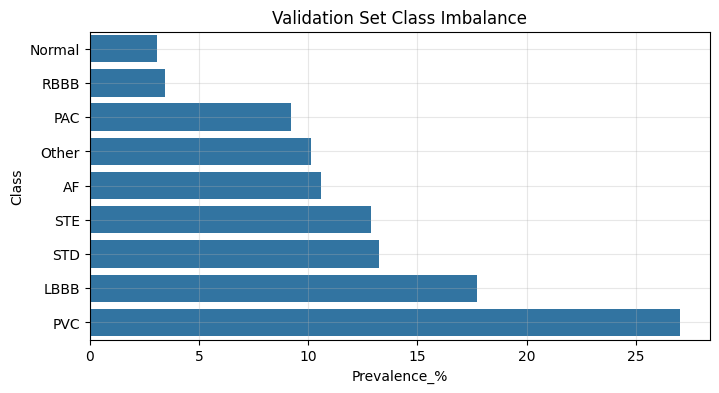

In [12]:
plt.figure(figsize=(8,4))
sns.barplot(data=imb_df, x="Prevalence_%", y="Class")
plt.title("Validation Set Class Imbalance")
plt.grid(True, alpha=0.3)
plt.show()

## Step 8: Per-Class Threshold Optimization

In [13]:
from sklearn.metrics import f1_score

def optimize_thresholds(y_true, y_prob, grid=np.linspace(0.1, 0.9, 17)):
    thresholds = []
    for c in range(y_true.shape[1]):
        best_f1, best_t = 0, 0.5
        for t in grid:
            f1 = f1_score(y_true[:, c], (y_prob[:, c] >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thresholds.append(best_t)
    return np.array(thresholds)

opt_thresholds = optimize_thresholds(y_true, y_prob)
opt_thresholds

array([0.65, 0.6 , 0.5 , 0.4 , 0.55, 0.35, 0.4 , 0.4 , 0.35])

## Step 9: Metrics AFTER Threshold Optimization

In [14]:
y_pred_opt = (y_prob >= opt_thresholds).astype(int)

metrics_opt = {
    "Hamming Loss": hamming_loss(y_true, y_pred_opt),
    "F1 Macro": f1_score(y_true, y_pred_opt, average="macro"),
    "F1 Micro": f1_score(y_true, y_pred_opt, average="micro"),
}

metrics_opt

{'Hamming Loss': 0.037645865043125316,
 'F1 Macro': 0.7879954374774809,
 'F1 Micro': 0.8413852073535699}

## Step 10: Before vs After

In [15]:
comp = pd.DataFrame({
    "Metric": ["Hamming Loss","F1 Macro","F1 Micro"],
    "Before (0.5)": [metrics_base["Hamming Loss"], metrics_base["F1 Macro"], metrics_base["F1 Micro"]],
    "After (Optimized)": [metrics_opt["Hamming Loss"], metrics_opt["F1 Macro"], metrics_opt["F1 Micro"]],
})
comp

,Metric,Before (0.5),After (Optimized)
0,Hamming Loss,0.043125,0.037646
1,F1 Macro,0.772704,0.787995
2,F1 Micro,0.823871,0.841385


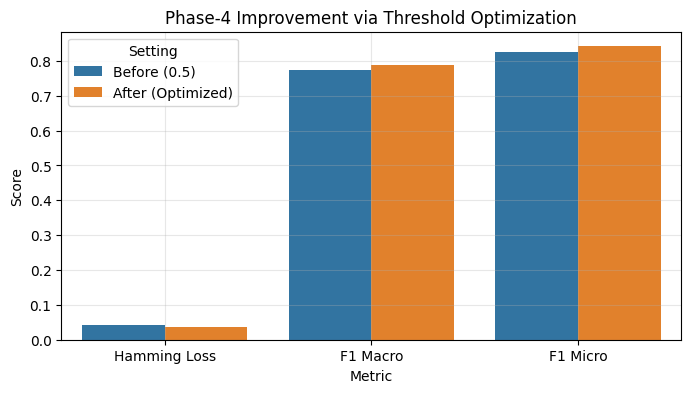

In [16]:
comp_m = comp.melt(id_vars="Metric", var_name="Setting", value_name="Score")
plt.figure(figsize=(8,4))
sns.barplot(data=comp_m, x="Metric", y="Score", hue="Setting")
plt.title("Phase-4 Improvement via Threshold Optimization")
plt.grid(True, alpha=0.3)
plt.show()

## Step 11: Subset Accuracy

### (a) Import Subset Accuracy Metric

In [17]:
from sklearn.metrics import accuracy_score

### (b) Subset Accuracy (Default Threshold = 0.5)

In [18]:
# Subset Accuracy BEFORE threshold optimization
y_pred_default = (y_prob >= 0.5).astype(int)

subset_acc_before = accuracy_score(y_true, y_pred_default)

print(f"Subset Accuracy (threshold = 0.5): {subset_acc_before:.4f}")

Subset Accuracy (threshold = 0.5): 0.7425


### (c) Subset Accuracy (After Per-Class Threshold Optimization)

In [19]:
# Subset Accuracy AFTER threshold optimization
y_pred_optimized = (y_prob >= opt_thresholds).astype(int)

subset_acc_after = accuracy_score(y_true, y_pred_optimized)

print(f"Subset Accuracy (optimized thresholds): {subset_acc_after:.4f}")

Subset Accuracy (optimized thresholds): 0.7689


### (d) Update the Comparison Table

In [20]:
comp_subset = pd.DataFrame({
    "Metric": ["Hamming Loss", "F1 Macro", "F1 Micro", "Subset Accuracy"],
    "Before (0.5)": [
        metrics_base["Hamming Loss"],
        metrics_base["F1 Macro"],
        metrics_base["F1 Micro"],
        subset_acc_before
    ],
    "After (Optimized)": [
        metrics_opt["Hamming Loss"],
        metrics_opt["F1 Macro"],
        metrics_opt["F1 Micro"],
        subset_acc_after
    ],
})

comp_subset

,Metric,Before (0.5),After (Optimized)
0,Hamming Loss,0.043125,0.037646
1,F1 Macro,0.772704,0.787995
2,F1 Micro,0.823871,0.841385
3,Subset Accuracy,0.742466,0.768950


###  (e) Visualization Including Subset Accuracy

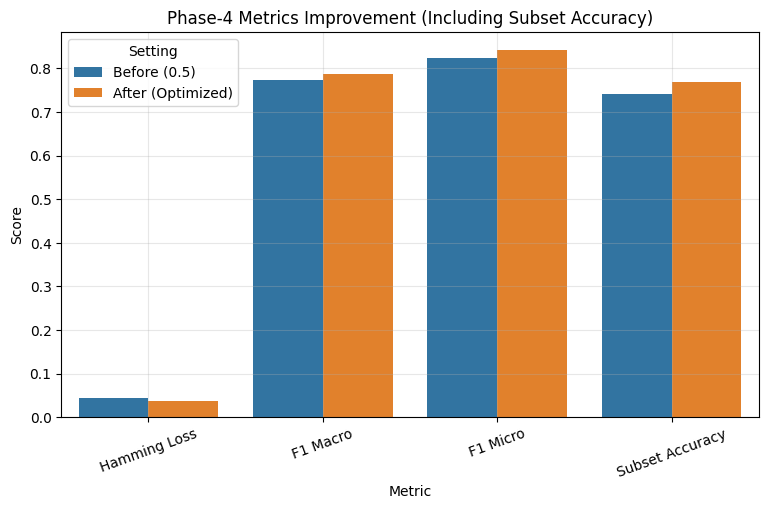

In [21]:
comp_m = comp_subset.melt(
    id_vars="Metric",
    var_name="Setting",
    value_name="Score"
)

plt.figure(figsize=(9,5))
sns.barplot(
    data=comp_m,
    x="Metric",
    y="Score",
    hue="Setting"
)
plt.title("Phase-4 Metrics Improvement (Including Subset Accuracy)")
plt.xticks(rotation=20)
plt.grid(True, alpha=0.3)
plt.show()
